<a href="https://colab.research.google.com/github/akkipant/CSEE490-Python-and-Deep-Learning-Programming/blob/master/LAB_2/Source/Q4/Lab2_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir ../root/.kaggle

In [0]:
!cp -rf kaggle.json ../root/.kaggle/

In [0]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews -p Q4

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 39.0MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 85.6MB/s]
  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 68.8MB/s]


In [0]:
!unzip /content/Q4/test.tsv.zip -d /content/Q4/

Archive:  /content/Q4/test.tsv.zip
  inflating: /content/Q4/test.tsv    


In [0]:
!unzip /content/Q4/train.tsv.zip -d /content/Q4/

Archive:  /content/Q4/train.tsv.zip
  inflating: /content/Q4/train.tsv   


In [0]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Package punkt is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Package wordnet is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

(156060, 5)
(66292, 4)
(156060,) (156060,) (156060, 5)
(117045, 48) (39015, 48) (66292, 48)
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 48, 100)           4800      
_________________________________________________________________
dropout_65 (Dropout)         (None, 48, 100)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 46, 64)            19264     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1472)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               188544    
___________________________

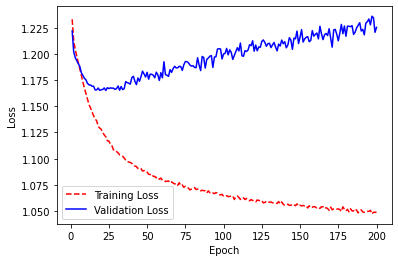

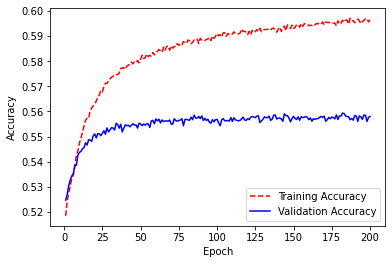

In [0]:
import numpy as np
import pandas as pd
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import MaxPooling1D,Dense,Dropout,Embedding,GlobalMaxPooling1D,Flatten
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from string import punctuation
import re

warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

gc.collect()

#loading data from TSV files
train=pd.read_csv('Q4/train.tsv',sep='\t')
test=pd.read_csv('Q4/test.tsv',sep='\t')

gc.collect()

def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

def cnnModel(max_features, max_words):
    model= Sequential()
    model.add(Embedding(max_features, 100, input_length=max_words))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()

train['clean_review']=clean_review(train.Phrase.values)
print(train.shape)
test['clean_review']=clean_review(test.Phrase.values)
print(test.shape)


train_text=train.clean_review.values
test_text=test.clean_review.values
target=train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

#Split data into train and validation
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.25,stratify=y,random_state=80)


all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)

r_len = []
for text in X_train_text:
    word = word_tokenize(text)
    l = len(word)
    r_len.append(l)

MAX_REVIEW_LEN = np.max(r_len)

max_features = 48
max_words = MAX_REVIEW_LEN
batch_size = 128

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)


X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

model = cnnModel(max_features, max_words)

model.summary()
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=200, batch_size=batch_size, verbose=1)


# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()